In [228]:
import pandas as pd
import numpy as np
from selenium.common import InvalidArgumentException

In [229]:
df = pd.read_csv("../wines_dataframe.csv", encoding="cp1252")
df.head()

,name,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
0,"Vino Tracer Riesling, Weinkellerei Hechtsheim,...",-0.229692,3,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,-1.133567,-0.121366
1,"Vino Lighea, Donnafugata, 2021",-0.180184,4,0,0,2,0,0,0,2,...,0,0,2,0,0,0,0,2,-0.695962,-0.121366
2,"Vino Chenin Blanc, David & Nadia, 2022",-0.155955,1,0,0,3,0,0,0,3,...,0,0,3,0,0,0,0,3,-0.695962,-0.121366
3,"Vino Pinot Noir Alpine Vineyard, Rhys Vineyard...",0.223636,5,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,-0.345878,-0.121366
4,"Vino Grain de Gris, Listel, 2022",-0.228602,2,0,1,1,0,0,1,1,...,0,1,1,0,0,0,1,1,-1.133567,-0.121366


### Можно заметить, что количество признаков уменьшилось

Это из-за того, что я изменил применение __One-Hot-Encoding__ на `BaseNEncoder`, ибо 723 признака слишком сильно влияли на перформанс

In [230]:
from abc import ABC, abstractmethod

In [231]:
class Kernel(ABC):

    @abstractmethod
    def compute(self, x: float):
        pass


class UniformKernel(Kernel):
    def compute(self, x: float):
        return 0.5 * (abs(x) < 1)


class GaussianKernel(Kernel):
    def compute(self, x: float):
        return np.exp(-0.5 * (abs(x) < 1))


class EpanechnikovKernel(Kernel):
    def compute(self, x: float):
        return 0.75 * (1 - x ** 2) * (abs(x) < 1)


class TriangularKernel(Kernel):
    def compute(self, x: float):
        return (1 - abs(x)) * (abs(x) < 1)


class CommonKernel(Kernel):
    def __init__(self, a: float, b: float):
        self.a = a
        self.b = b

    def compute(self, x: float):
        return (1 - abs(x) ** self.a) ** self.b * (abs(x) < 1)

In [232]:
columns = df.columns
for column in columns:
    try:
        df[column] = df[column].astype(float)
    except ValueError:
        pass

df.head()

,name,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
0,"Vino Tracer Riesling, Weinkellerei Hechtsheim,...",-0.229692,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.133567,-0.121366
1,"Vino Lighea, Donnafugata, 2021",-0.180184,4.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,-0.695962,-0.121366
2,"Vino Chenin Blanc, David & Nadia, 2022",-0.155955,1.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,-0.695962,-0.121366
3,"Vino Pinot Noir Alpine Vineyard, Rhys Vineyard...",0.223636,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.345878,-0.121366
4,"Vino Grain de Gris, Listel, 2022",-0.228602,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.133567,-0.121366


## Перейдем к метрикам

In [233]:
def minkowski(X: list[float], Y: list[float], p: float = 2) -> float:
    sm = 0.0
    for (x, y) in zip(X, Y):
        sm += abs(x - y) ** p
    return sm ** (1 / p)


def cosine(X: list[float], Y: list[float]) -> float:
    mul = np.dot(X, Y)
    l1 = np.linalg.norm(X)
    l2 = np.linalg.norm(Y)
    return mul / (l1 * l2)


def chebyshev(X: list[float], Y: list[float]) -> float:
    return max(abs(x - y) for (x, y) in zip(X, Y))


def euclidian(X: list[float], Y: list[float]) -> float:
    return minkowski(X, Y, 2)


def manhattan(X: list[float], Y: list[float]) -> float:
    return minkowski(X, Y, 1)


metrics = [
    minkowski,
    cosine,
    euclidian,
    manhattan
]

## Теперь разобъем датасет на train и test

In [234]:
df.columns

Index(['name', 'price', 'rating', 'country_0', 'country_1', 'country_2',
       'region_0', 'region_1', 'region_2', 'region_3', 'sweetness_0',
       'sweetness_1', 'grape_0', 'grape_1', 'grape_2', 'grape_3',
       'manufacturer_0', 'manufacturer_1', 'manufacturer_2', 'manufacturer_3',
       'manufacturer_4', 'strength', 'volume'],
      dtype='object')

In [235]:
TARGET = "rating"

In [236]:
def train_test_split(dataframe: pd.DataFrame, test_size: float = 0.2) -> tuple:
    test = dataframe.sample(frac=test_size)
    train = dataframe.drop(test.index)
    return train, test

In [237]:
train, test = train_test_split(df.drop(["name"], axis=1))

In [238]:
train.head()

,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,sweetness_0,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
1,-0.180184,4.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,-0.695962,-0.121366
2,-0.155955,1.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,-0.695962,-0.121366
3,0.223636,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.345878,-0.121366
4,-0.228602,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.133567,-0.121366
7,-0.173454,5.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.179247,-0.121366


In [239]:
test.head()

,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,sweetness_0,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
1435,0.109221,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,3.0,2.0,1.054457,-0.121366
880,-0.190562,2.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,...,0.0,2.0,1.0,0.0,0.0,2.0,2.0,3.0,0.179247,-0.121366
2078,-0.223891,2.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,...,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,-0.258357,-0.121366
900,-0.221912,1.0,0.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,...,0.0,2.0,1.0,0.0,3.0,3.0,2.0,2.0,-0.258357,-0.121366
1349,-0.011926,3.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,...,0.0,2.0,3.0,0.0,2.0,0.0,1.0,1.0,1.929667,-0.121366


### Кажется норм

In [266]:
from typing import Callable, Union
from sklearn.neighbors import NearestNeighbors


class KNNClassifier:
    def __init__(self, k: int, radius: float, kernel: Kernel,
                 metric: Callable[[list[float], list[float]], float] = euclidian, mode: str = "fixed",
                 algorithm: str = "ball_tree"):
        """
        KNNClassifier class
        
        :param k: amount of neighbors to compute. While computing kernel distance, dist to k + 1st neighbor will be used
        :param radius: radius of a fixed window where neighbors are computed
        :param kernel: kernel function to compute weights
        :param metric: metric for distance computation
        :param mode: fixed window or non-fixed window
        :param algorithm: algorithm to use for neighbors finding (ball tree or K-D tree)
        """
        self.neighbors = k + 1
        self.radius = radius
        self.metric = metric
        self.kernel = kernel

        if mode not in ["fixed", "non-fixed"]:
            raise ValueError("Mode must be either fixed or non-fixed")
        self.mode = mode
        self.algorithm = algorithm if algorithm in ["ball_tree", "kd_tree"] else "auto"
        self.tree = None
        self.classes = None
        self.weights = None


    def __get_classes(self, distances: np.array, indices: np.array, divider: float) -> dict:
        classes = {}
        for ind, dist in zip(indices, distances):
            multiplier = self.kernel.compute(dist / divider) #  * self.__get_weight(ind)
            target_class = self.classes.iloc[ind]
            if target_class not in classes:
                classes[target_class] = 0
            classes[target_class] += multiplier
        return classes

    def fit(self, X: pd.DataFrame, y: pd.Series, weights: pd.Series = None):
        if self.algorithm == "kd_tree":
            self.tree = NearestNeighbors(n_neighbors=self.neighbors
                                         , radius=self.radius
                                         , algorithm=self.algorithm
                                         , metric=self.metric.__name__).fit(X)
        else:
            self.tree = NearestNeighbors(n_neighbors=self.neighbors
                                         , radius=self.radius
                                         , algorithm=self.algorithm
                                         , metric=self.metric).fit(X)
        self.classes = y
        self.weights = weights

    def predict(self, point: list[float], predict_proba: bool = False) -> Union[float, tuple[float, float]]:
        if self.tree is None:
            raise RuntimeError("KNNClassifier has not been fit yet.")

        if self.mode == "fixed":
            rng = self.tree.radius_neighbors(point, return_distance=True, sort_results=True)
            distances = np.asarray(rng[0][0])
            indices = np.asarray(rng[1][0])
            classes = self.__get_classes(distances, indices, self.radius)
        else:
            rng = self.tree.kneighbors(point, return_distance=True)
            distances = np.asarray(rng[0][0])
            indices = np.asarray(rng[1][0])
            classes = self.__get_classes(distances, indices, max(distances))

        mx = -1
        ans = 0
        for key in classes:
            if classes[key] > mx:
                mx = classes[key]
                ans = key

        if predict_proba:
            proba = classes[ans] / sum(classes.values())
            return ans, proba
        return ans   

### Осталось собственно попробовать что-нибудь предсказать

In [241]:
train.head()

,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,sweetness_0,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
1,-0.180184,4.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,-0.695962,-0.121366
2,-0.155955,1.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,-0.695962,-0.121366
3,0.223636,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.345878,-0.121366
4,-0.228602,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,-1.133567,-0.121366
7,-0.173454,5.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.179247,-0.121366


In [242]:
test.head()

,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,sweetness_0,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
1435,0.109221,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,3.0,2.0,1.054457,-0.121366
880,-0.190562,2.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,...,0.0,2.0,1.0,0.0,0.0,2.0,2.0,3.0,0.179247,-0.121366
2078,-0.223891,2.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,...,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,-0.258357,-0.121366
900,-0.221912,1.0,0.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,...,0.0,2.0,1.0,0.0,3.0,3.0,2.0,2.0,-0.258357,-0.121366
1349,-0.011926,3.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,...,0.0,2.0,3.0,0.0,2.0,0.0,1.0,1.0,1.929667,-0.121366


In [243]:
y_train = train[TARGET]
small_y = y_train[:3]
small_y

1    4.0
2    1.0
3    5.0
Name: rating, dtype: float64

In [244]:
train["rating"].iloc[:3]

1    4.0
2    1.0
3    5.0
Name: rating, dtype: float64

In [245]:
train.iloc[2220:2221]

,price,rating,country_0,country_1,country_2,region_0,region_1,region_2,region_3,sweetness_0,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
2775,-0.059038,1.0,0.0,2.0,0.0,0.0,0.0,3.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,-0.258357,-0.121366


In [246]:
X_train = train.drop(TARGET, axis=1)
y_train = train[TARGET]
y_train.iloc[0]

4.0

In [247]:
knn = KNNClassifier(k=10, radius=10, kernel=GaussianKernel(), metric=euclidian, algorithm="ball_tree")
# knn.predict(train.iloc[:1])

In [248]:
knn.fit(X_train, y_train)
knn.predict(X_train.iloc[:1])

5.0

In [249]:
knn.predict(X_train.iloc[1:2])

5.0

### Ого, оно даже работает
### Теперь давайте нормально попредсказываем и посмотрим, насколько хорошо (или плохо) оно работает

In [250]:
from sklearn.metrics import f1_score

### Попробуем заняться подбором гиперпараметров

In [276]:
from typing import Optional


class GridResult:
    def __init__(self):
        self.best_micro_fscore = None
        self.best_macro_fscore = None
        
        self.best_micro_estimator = None
        self.best_macro_estimator = None
        
        self.best_micro_params = {}
        self.best_macro_params = {}
        
    def update_micro(self, estimator: KNNClassifier, score: float, params: dict):
        if self.best_micro_fscore is None or self.best_micro_fscore < score:
            self.best_micro_fscore = score
            self.best_micro_estimator = estimator
            self.best_micro_params = params
    
    def update_macro(self, estimator: KNNClassifier, score: float, params: dict):
        if self.best_macro_fscore is None or self.best_macro_fscore < score:
            self.best_macro_fscore = score
            self.best_macro_estimator = estimator
            self.best_macro_params = params


def get_k(params: dict) -> Optional[list[int]]:
    return params["k"] if "k" in params else None

def get_radius(params: dict) -> Optional[list[float]]:
    return params["radius"] if "radius" in params else None

def get_metric(params: dict) -> Optional[list[Callable[[list[float], list[float]], float]]]:
    return params["metric"] if "metric" in params else None

def get_mode(params: dict) -> Optional[list[str]]:
    return params["mode"] if "mode" in params else None

def get_algorithm(params: dict) -> Optional[list[str]]:
    return params["algorithm"] if "algorithm" in params else None

def get_kernel(params: dict) -> Optional[list[Kernel]]:
    return params["kernel"] if "kernel" in params else None


def grid_search(X: pd.DataFrame, y: pd.Series, params: dict) -> GridResult:
    """
    :param X: Data used to fit KNNClassifier
    :param y: Data target values used to fit KNNClassifier
    :param params: dictionary of parameters that will be used for grid search
                   Every entry must look like "param": list[possible_variations]
    :return: KNNClassifier object with best score
    """
    
    result = GridResult()

    k = get_k(params)
    radius = get_radius(params)
    metric = get_metric(params)
    mode = get_mode(params)
    algorithm = get_algorithm(params)
    kernel = get_kernel(params)

    for _mode in mode:
        for _metric in metric:
            for _algorithm in algorithm:
                for _kernel in kernel:
                    for _k, _radius in zip(k, radius):
                        knn = KNNClassifier(k=_k
                                            , radius=_radius
                                            , kernel=_kernel
                                            , metric=_metric
                                            , algorithm=_algorithm
                                            , mode=_mode)
                        knn.fit(X, y)
                        predictions = []
                        for idx in range(X.shape[0]):
                            point = X.iloc[idx:idx + 1]
                            predictions.append(knn.predict(point))
                        
                        micro_fscore = f1_score(y.tolist(), predictions, average="micro")
                        macro_fscore = f1_score(y.tolist(), predictions, average="macro")
                        
                        _params = {
                            "k": _k,
                            "radius": _radius,
                            "metric": _metric,
                            "mode": _mode,
                            "algorithm": _algorithm,
                            "kernel": _kernel
                        }
                        
                        result.update_micro(knn, micro_fscore, _params)
                        result.update_macro(knn, macro_fscore, _params)
                            
    return result

In [252]:
# params = {
#     "k": [3, 5, 10],
#     "radius": [0.5, 2, 5, 10, 50],
#     "metric": metrics,
#     "mode": ["fixed", "non-fixed"],
#     "algorithm": ["ball_tree"],
#     "kernel": [GaussianKernel(), UniformKernel(), TriangularKernel(), EpanechnikovKernel()]
# }
# 
# best = grid_search(X_train, y_train, params)
# print(f"Best micro score - {best.best_micro_fscore}")
# print(f"Best micro params - {best.best_micro_params}", sep='\n')
# print("-------------------")
# print(f"Best macro score - {best.best_macro_fscore}")
# print(f"Best macro params - {best.best_macro_params}", sep='\n')


#### Этот перебор, к сожалению, работает примерно за 50 минут

In [269]:
# knn = best.best_macro_estimator
best_params = {
    'k': 5,
    "radius": 0.5,
    "metric": manhattan,
    "mode": "fixed",
    "algorithm": "ball_tree",
    "kernel": GaussianKernel()
}

In [254]:
knn = KNNClassifier(
    k=3,
    radius=0.5,
    metric=manhattan,
    mode="fixed",
    algorithm="ball_tree",
    kernel=GaussianKernel()
)

knn.fit(X_train, y_train)

In [255]:
y_pred = []
for idx in range(X_train.shape[0]):
    point = X_train.iloc[idx:idx + 1]
    y_pred.append(knn.predict(point))

micro_fscore = f1_score(y_train, y_pred, average="micro")
print(f"Micro F-score on train data - {micro_fscore}")
print(f"Macro F-score on train data - {f1_score(y_train, y_pred, average='macro')}")

Micro F-score on train data - 0.9176046825754165
Macro F-score on train data - 0.9129930433935692


### Выше можно увидеть, что получилось достичь довольно неплохого результата - `F-score` равный $\sim$ 0.9
### Однако данное значение было достигнуто на тренировочном датасете, давайте провалидируем его на тестовом

In [256]:
X_test = test.drop(TARGET, axis=1)
y_test = test[TARGET]

y_pred = []
for idx in range(X_test.shape[0]):
    point = X_test.iloc[idx:idx + 1]
    y_pred.append(knn.predict(point))

micro_fscore = f1_score(y_test, y_pred, average="micro")
print(f"Micro F-score on test data - {micro_fscore}")
print(f"Macro F-score on test data - {f1_score(y_test, y_pred, average='macro')}")

Micro F-score on test data - 0.5693693693693693
Macro F-score on test data - 0.588542966987723


### Нетрудно видеть, что ситуация с тестовыми данными ощутимо хуже (однако все равно лучше, чем было без `grid_search`)

### Реализуем алгоритм поиска аномалий _LOWESS_

In [270]:
def get_all_proba_predictions(X: pd.DataFrame, y: pd.Series, params: dict) -> list[float]:
    knn = KNNClassifier(k=params["k"],
                        radius=params["radius"],
                        kernel=params["kernel"],
                        mode="non-fixed",
                        algorithm=params["algorithm"],
                        metric=params["metric"])
    
    proba_predictions = []
    for idx in range(X.shape[0]):
        point = X.iloc[idx:idx + 1]
        X_local = X.drop(X.index[idx])
        y_local = y.drop(y.index[idx])
        knn.fit(X_local, y_local)
        proba_predictions.append(knn.predict(point, predict_proba=True)[1])
    
    return proba_predictions


def predict_lowess(X: pd.DataFrame, y: pd.Series, params: dict,  new_kernel: Kernel = None) -> list[float]:
    proba_predictions = get_all_proba_predictions(X, y, params)
    
    knn = KNNClassifier(k=params["k"],
                        radius=params["radius"],
                        kernel=params["kernel"],
                        mode="non-fixed",
                        algorithm=params["algorithm"],
                        metric=params["metric"])

    predictions = []
    if new_kernel is None:
        new_kernel = params["kernel"]

    for idx in range(X.shape[0]):
        p = X.iloc[idx:idx + 1]
        X_local = X.drop(X.index[idx])
        knn.fit(X_local, y)
        rng = knn.tree.radius_neighbors(p, return_distance=True, sort_results=True)
        distances = np.asarray(rng[0][0])
        indices = np.asarray(rng[1][0])

        classes = {}
        for ind, dist in zip(indices, distances):
            divider = knn.radius if knn.mode == "fixed" else max(distances)
            multiplier = new_kernel.compute(dist / divider)
            target_class = y.iloc[ind]
            if target_class not in classes:
                classes[target_class] = 0
            classes[target_class] += multiplier * new_kernel.compute(1 - proba_predictions[idx])
        
        mx = 0
        ans = 0
        for key in classes:
            if classes[key] > mx:
                mx = classes[key]
                ans = key
        predictions.append(ans)
    
    return predictions
        

In [258]:
X_test.head()

,price,country_0,country_1,country_2,region_0,region_1,region_2,region_3,sweetness_0,sweetness_1,...,grape_1,grape_2,grape_3,manufacturer_0,manufacturer_1,manufacturer_2,manufacturer_3,manufacturer_4,strength,volume
1435,0.109221,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,...,0.0,1.0,1.0,0.0,1.0,1.0,3.0,2.0,1.054457,-0.121366
880,-0.190562,0.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,2.0,...,0.0,2.0,1.0,0.0,0.0,2.0,2.0,3.0,0.179247,-0.121366
2078,-0.223891,0.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,1.0,...,0.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,-0.258357,-0.121366
900,-0.221912,0.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,...,0.0,2.0,1.0,0.0,3.0,3.0,2.0,2.0,-0.258357,-0.121366
1349,-0.011926,0.0,0.0,2.0,0.0,0.0,3.0,2.0,0.0,2.0,...,0.0,2.0,3.0,0.0,2.0,0.0,1.0,1.0,1.929667,-0.121366


In [259]:
y_test.head(6)

1435    1.0
880     2.0
2078    2.0
900     1.0
1349    3.0
804     5.0
Name: rating, dtype: float64

In [271]:
y_pred = predict_lowess(X_test, y_test, best_params)

C:\Users\aww\AppData\Local\Temp\ipykernel_14500\457948208.py:47: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = new_kernel.compute(dist / divider)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\457948208.py:47: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = new_kernel.compute(dist / divider)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\457948208.py:47: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = new_kernel.compute(dist / divider)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\457948208.py:47: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = new_kernel.compute(dist / divider)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\457948208.py:47: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = new_kernel.compute(dist / divider)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\457948208.py:47: RuntimeWarning: invalid value encountered in scalar divide
  mult

In [275]:
micro_fscore = f1_score(y_test, y_pred, average="micro")
print(f"Micro F-score on test data - {micro_fscore}")
print(f"Macro F-score on test data - {f1_score(y_test, y_pred, average='macro')}")

Micro F-score on test data - 0.23603603603603604
Macro F-score on test data - 0.21922838837194517


In [278]:
list(zip([1, 2, 3], [1, 2, 3, 4, 5]))

[(1, 1), (2, 2), (3, 3)]

### Время строить графики
Для начала посмотрим на фиксированный размер окна

In [281]:


radii = [0.5, 1, 2, 5, 7, 10, 15, 20, 50]

micro_fixed = []
macro_fixed = []

for radius in radii:
    knn = KNNClassifier(k=0,
                        radius=radius,
                        kernel=GaussianKernel(),
                        mode="fixed",
                        algorithm="ball_tree",
                        metric=manhattan)
    
    knn.fit(X_train, y_train)
    predictions = []
    for idx in range(X_train.shape[0]):
        point = X_train.iloc[idx:idx + 1]
        predictions.append(knn.predict(point))
    
    micro_fscore = f1_score(y_train.tolist(), predictions, average="micro")
    macro_fscore = f1_score(y_train.tolist(), predictions, average="macro")
    
    micro_fixed.append(micro_fscore)
    macro_fixed.append(macro_fscore)


In [282]:
%matplotlib inline
import matplotlib.pyplot as plt

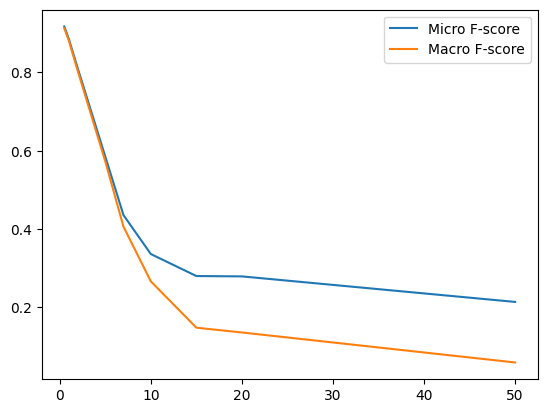

In [284]:
plt.plot(radii, micro_fixed)
plt.plot(radii, macro_fixed)
plt.legend(["Micro F-score", "Macro F-score"])
plt.show()

In [285]:
ks = [3, 4, 5, 8, 10, 12]

micro_non_fixed = []
macro_non_fixed = []

for k in ks:
    knn = KNNClassifier(k=k,
                        radius=1,
                        kernel=GaussianKernel(),
                        mode="non-fixed",
                        algorithm="ball_tree",
                        metric=manhattan)
    
    knn.fit(X_train, y_train)
    predictions = []
    for idx in range(X_train.shape[0]):
        point = X_train.iloc[idx:idx + 1]
        predictions.append(knn.predict(point))
    
    micro_fscore = f1_score(y_train.tolist(), predictions, average="micro")
    macro_fscore = f1_score(y_train.tolist(), predictions, average="macro")
    
    micro_non_fixed.append(micro_fscore)
    macro_non_fixed.append(macro_fscore)


C:\Users\aww\AppData\Local\Temp\ipykernel_14500\3305923653.py:36: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = self.kernel.compute(dist / divider) #  * self.__get_weight(ind)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\3305923653.py:36: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = self.kernel.compute(dist / divider) #  * self.__get_weight(ind)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\3305923653.py:36: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = self.kernel.compute(dist / divider) #  * self.__get_weight(ind)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\3305923653.py:36: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = self.kernel.compute(dist / divider) #  * self.__get_weight(ind)
C:\Users\aww\AppData\Local\Temp\ipykernel_14500\3305923653.py:36: RuntimeWarning: invalid value encountered in scalar divide
  multiplier = self.kernel.compute(dist / divider) #  * sel

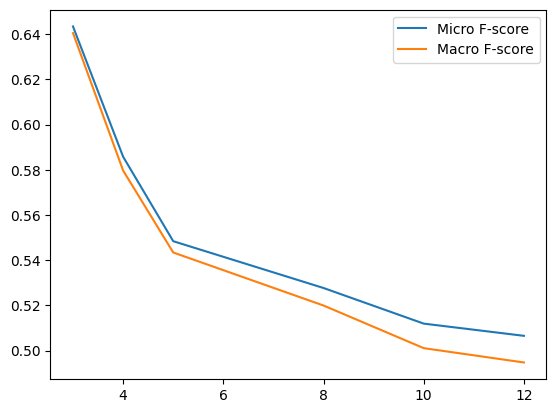

In [286]:
plt.plot(ks, micro_non_fixed)
plt.plot(ks, macro_non_fixed)
plt.legend(["Micro F-score", "Macro F-score"])
plt.show()